# Titanic Survival Prediction with Tensorflow

*The following notebook was written completely from scratch by Jacob Valdez (no stackoverflow, no tutorials, no Google, no Internet!) to complete the "Term Project Tutorial" for Data Mining.*

Building and training a binary classifier is easy! I'll walk you through the steps below. It should only take 2 minutes to follow along. (Or if you want to clone from my Github repo, 30 seconds)

## Getting Started

Make sure you have numpy, pandas, tensorflow, matplotlib, and seaborn installed.

In [ ]:
!pip install numpy pandas tensorflow matplotlib seaborn

If you're running jupyter lab locally, you may want to enable the `Completer` to get intelisense popups.

In [1]:
%config Completer.use_jedi=False

Now import the above libraries

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis

Let's start by loading our data (You'll have to change the paths below):

In [3]:
train_data = pd.read_csv('~/Downloads/train.csv')
test_data = pd.read_csv('~/Downloads/test.csv')
train_data #, test_data (don't look at your test data! ;) ) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Now we want to get several 'tastes' of the data. We'll take a few different perspectives below

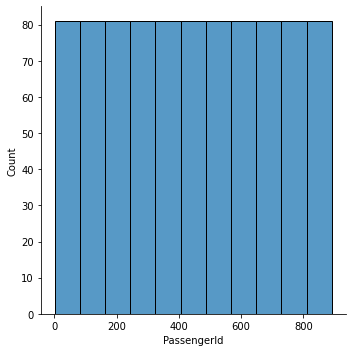

In [4]:
sns.displot(x='PassengerId', data=train_data)

Ok, good. `PassengerId` is uniformly distributed across the 1 to 891.

Let's look at some other attributes:

ValueError: Invalid RGBA argument: 'Survived'

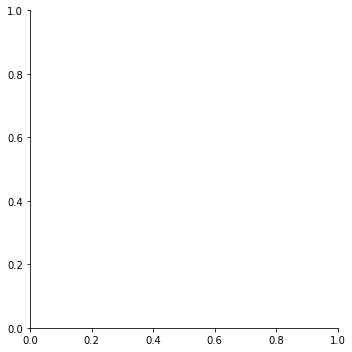

In [5]:
sns.displot(x='Age', y='Pclass',
           color='Survived', data=train_data)

Whoops! I'm not hiding my errors in this notebook because I want to guide you through similar problems that you may encounter. The above error says, `ValueError: Invalid RGBA argument: 'Survived'` I'm guessing that means `seaborn.displot` was expecting a 3-tuple or 4-tuple for the `color` parameter. To resolve this issue, I remembered using the `hue` arguement with a scalar column with the lineplot. Let's see if `hue` works in the above case:  

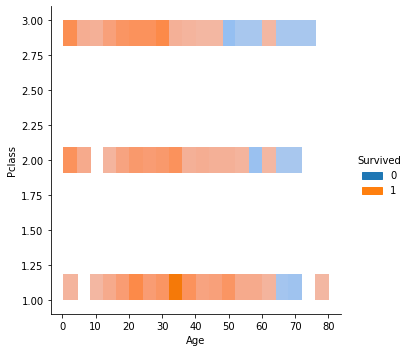

In [6]:
sns.displot(x='Age', y='Pclass',
           hue='Survived', data=train_data)

It works! Now you can see that there are only three classes. More importantly, note that the age variation of survival rate increases with `Pclass`.

Let's not stop exploring our data. Guided by intuition and curiosity, I select the following attributes:

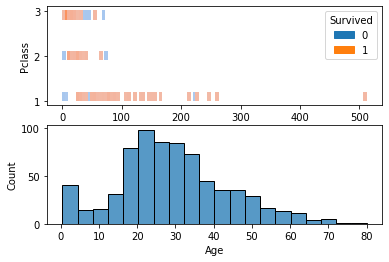

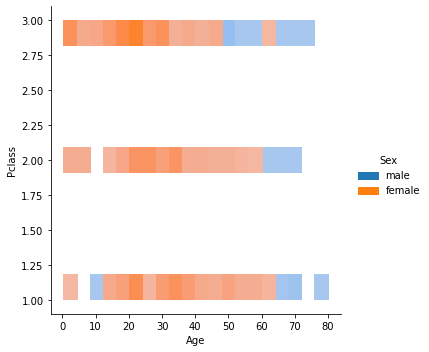

In [7]:
fig, [ax1, ax2] = plt.subplots(2)

sns.histplot(x='Fare', y='Pclass',
           hue='Survived', data=train_data,
           ax=ax1)

sns.histplot(train_data['Age'],
            ax=ax2)

sns.displot(x='Age', y='Pclass',
           hue='Sex', data=train_data)

I'm sure there's alot to pull out of these figures. Survival classification is not an intuitive problem. Take a minute or two to make your own analyses, and think about how you will make a your own program that predicts if a passenger survived.

---

Now that you have an idea about how you might start developing a survival classifier, let me share the good news: We can use machine learning to classify if a patient will survive without actually learning the deep data trends ourselves.

## Converting the data

We want to convert as much data as possible into machine readable form. For the purpose of this simple tutorial, let's drop textual data (see the Appendix if you're curious on how it might be parsed) and only utilize numerical or categorical data to classify passenger survival.

If you forgot what the data looks like:

In [8]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


It looks like we need to convert `Sex` and `Embarked` into integer class ID's. You can do this by:

In [9]:
embarked_map = {
    'S': 0,
    'C': 1,
    'Q': 2,
}

def mapE(v):
    if v in embarked_map:
        return embarked_map[v]
    else:
        print(v)
        return 3

train_data_modified = train_data.copy()
train_data_modified['Sex'] = train_data_modified.apply(
    lambda x : 0 if x.Sex == 'male' else 1, axis=1)
train_data_modified['Embarked'] = train_data_modified.apply(
    lambda x : mapE(x.Embarked), axis=1)
train_data_modified

nan
nan


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,NaN,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,1


I first copied the origonal dataset into `train_data_modified` so that I could test the above code cell multiple times while resolving syntax issues but not modify the ground truth `train_data`. I'm sure there are better ways to do this, but I'm just looking for a one-off answer right now. MLops is big on fast, imperfect-but-improving iterations, so you may find it convenient at times to follow this convention in your work.  

You'll probabbly also note that the above code treats the `Embarked` variable differently than `Sex`. I had to use that approach because a few variables were actually missing (they were `NaN` like you see in the `Age` column of row 888 above) There's actually several other not-a-numbers in the dataset. For our purposes, we'll override them with 0, but keep in mind that this can cause confusion in many scenerios.

In [10]:
for k in ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']:
    train_data_modified[k] = train_data_modified[k].apply(
        lambda x : 0 if np.isnan(x) else x)
train_data_modified

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,0.0,1,2,W./C. 6607,23.4500,NaN,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,1


Notice the `0` now present on row `888` above. We're ready to feed this to a neural network classifier.

## Building the network

You may have heard about 'deep learning' and 'neural networks' before. Don't let those fancy terms scare you. There's little true 'neural' inspiration to the networks were going to build, but its probabbly simpler for our purposes to think of the classifier as a statistical blackbox model that we can op-tim-ize to correctly identify the class of incoming data. This statistical model won't be your standard linear Bayesian classifier though. Instead, we'll use stacks of fully connected neural network layers (which are each like a multidimensional nonlinear version of Bayesian classifiers.) You might think of each weight in the network as a fuzzy-valued if-gate that partially decides whether some input value is relevant or not to the downstream or output value. 

To be precise, a fully connected layer looks like this:
$$y=f(xW+b)$$
where 
- $x \in \mathbb{R}^{n_x}$ are the input values
- $y \in \mathbb{R}^{n_y}$ are the output values 
- $W \in \mathbb{R}^{n_x \times n_y}$ is the weight matrix 
- $b \in \mathbb{R}^{n_y}$ are the bias values 
- $f \colon \mathbb{R}^{n_y} \mapsto \mathbb{R}^{n_y}$ is some elementwise, non-linear function like `relu` or `sigmoid`
- $xW$ is the matrix multipulcation operation between $x$ and $W$

There are several powerful deep learning libraries that simplify this mathematics, so we can practically ignore it for now. Take a look at `tensorflow.keras.layers.Dense`:

In [11]:
n_x = 20
n_y = 30

dense_layer = tf.keras.layers.Dense(units=n_y, activation=tf.nn.relu)
dense_layer

Let's run this layer on some random data and see what it outputs

In [12]:
input_val = tf.random.uniform(shape=(1, n_x), minval=0, maxval=1)

output_val = dense_layer(input_val)

input_val, output_val

(<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
 array([[0.56778884, 0.56160414, 0.893572  , 0.3229041 , 0.90937114,
         0.63573694, 0.35387146, 0.47441912, 0.60885704, 0.01633441,
         0.3315431 , 0.39821362, 0.70036566, 0.12150264, 0.28599095,
         0.9301748 , 0.12281406, 0.7980323 , 0.8837979 , 0.44928217]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 30), dtype=float32, numpy=
 array([[0.19415012, 0.        , 0.6113546 , 0.18879873, 0.        ,
         0.        , 0.34119648, 0.        , 0.        , 0.        ,
         0.32419968, 0.15420988, 0.        , 0.9238754 , 0.        ,
         0.4397241 , 0.        , 0.21186957, 0.077152  , 0.19395241,
         0.        , 0.        , 0.        , 0.24134715, 0.        ,
         0.29542112, 0.        , 0.        , 0.51963073, 0.72648084]],
       dtype=float32)>)

I forgot to mention: deep learning accelerators often have special support for parallel execution, so most high-level tensorflow and keras layers and operations expect data to be supplied in multiple batches simultaneously. We just made a single batch dimension by appendingn `(1,...)` to our input data shape.

You'll notice that about half of the output data values are zero. That's good because it means our dense layer weights are effectively normalizing the positive input data for us. A lot of times when you're stacking neural networks, you get layers that take in positive values and output unit normal values. Of course, the `relu` function truncates negative values, so they just show up on the output as `0.`.

As activations climb the layer hierarchy of a neural network, they successively acquire more certainty about their underlying significance and target representation. The previous layer was just an example. Let's now stack some more layers togethor. `keras` makes this easy with their `Sequential` API.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(6),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

This model takes in 6-dimensional data and passes it through 3 linear and nonlinear transforms to realize an output binary decision of survived `1` or did not survive `0`. Keras gives us a high level summary of this model via the `.summary` method:

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 581
Trainable params: 581
Non-trainable params: 0
_________________________________________________________________


Machine learning systems are data-hungry. Notice that our model has 581 trainable parameters. From an optimal machine learning perspective, that means we'll need at least 581 data values to train on. Our data set is $890 \times 5 \div 581\approx 7.66x$ bigger so we might have enough data to reasonably tune each parameter. If this first model doesn't work, then we can come back and build a smaller model or add some regularization.

Before we forget, let's specify the optimizer and loss function that we'd like to use. You hear optimization introduced as 'rolling the ball down the hill' alot, but in 581-dimensional space (rather than 3D), dynamics aren't as intuitive. As an effect, machine learning research has developed many methods to minimize objectives in high dimensional space. Let's start with the simplest `sgd`. Since our problem is binary classification, we'll use `binary_crossentropy` which gives a purer information-theoretic measure to optimality than say mean squared error. 

In [15]:
model.compile(optimizer='sgd', loss='binary_crossentropy')

## The training pipeline

Now that you can see the input shape of our model, I hope you see why our `pandas.DataFrame` isn't ready for direct neural network consumption. It needs to be converted to a numpy array:

In [16]:
# inputs:  'Pclass', 'Sex', 'Age', 'Fare', 'Embarked'
# outputs: 'Survived'

train_data_modified.head(0)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [17]:
train_data_modified = train_data_modified.drop(
    columns=['PassengerId', 'Name', 'SibSp', 'Ticket', 'Cabin'])
train_data_modified.head(0)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked


In [18]:
train_data_modified_arr = train_data_modified.to_numpy()
train_data_modified_arr.shape, train_data_modified_arr 

((891, 7),
 array([[ 0.    ,  3.    ,  0.    , ...,  0.    ,  7.25  ,  0.    ],
        [ 1.    ,  1.    ,  1.    , ...,  0.    , 71.2833,  1.    ],
        [ 1.    ,  3.    ,  1.    , ...,  0.    ,  7.925 ,  0.    ],
        ...,
        [ 0.    ,  3.    ,  1.    , ...,  2.    , 23.45  ,  0.    ],
        [ 1.    ,  1.    ,  0.    , ...,  0.    , 30.    ,  1.    ],
        [ 0.    ,  3.    ,  0.    , ...,  0.    ,  7.75  ,  2.    ]]))

We removed columns from `train_data_modified` that we won't need and then converted it to a `numpy.array`. Notice that for each column in this final dataframe, there is an equivalent column in the numpy array. The columns have the same ordering in both objects, so column 0 of the above matrix refers to `Survived`, column 1 to `Pclass`, column 2 to `Sex`, ... you get the idea. `numpy` and other multi-dimensional indexed Python objects support a special convention to slice a subset out of an array. We can use:

In [19]:
y_train = train_data_modified_arr[:, 0]
y_train.shape

(891,)

to retrieve just the first value from every row of `train_data_modified_arr`. We'll do something similar to extracted the rest of the input data:  

In [20]:
X_train = train_data_modified_arr[:, 1:]
X_train.shape

(891, 6)

There's a lot going on behind the scenes of those operations: First, you're starting with a two dimensional `np.array` `train_data_modified_arr` which has a shape (891, 7). Now when we're defining `y_train`, we only want to take the first item from the second axis of this tensor, but we want to do this for every unit along the first axis. We express this by writting the index slicing operation `[: , 0]` where the colon means 'do this for all units on my axis' and the `0` means 'take the first element'. Those statements are applied to the axes that they are ordered in, so we get the first element of the second axis for all units along the first axis as a result. 

It gets a little trickier with `X_train`, but the underlying rules are the same. The colon indexing statement `:` on its own filters nothing along its axis. However, when it is qualified by positive integers, they identify an inclusive-first exclusive-last index filter for selection. For example, `[0:5]` selects the first, second, third, forth, and fifth elements of a sequence (the last index is exclusive so we don't get the sixth element). If you leave one of the indeces blank, the array boundary is assumed, so `[:9]` selects all elements up to but not including the tenth element. Now putting this all togethor with multidimensional indexing, `[:, 1:]` selects all elements including and after the second element on the second axis for every example along the first axis.

It may seem confusing to think about all these shapes and indeces, but trust me, with data and mindset in tensor-form, the pipeline just takes off. The `tensorflow.keras` API makes it super easy to train our model from here. All we have to do is call the `.fit` method!

In [21]:
model.fit(x=X_train, y=y_train)

28/28 [==============================] - 1s 2ms/step - loss: 0.7807


It works! 🎉 Or does it? There were no programming syntax issues, but we still have to ask ourselves: 'Is the model doing what its supposed to do?' Let's repeat the above process multiple time (in ML lingo, for multiple epochs) and then visualize how the model training runs. To make training runs consistent, I'll make two code cells below: one to reinitialize the neural network and another to train and visualize improvement. In anything bigger than this tutorial, you'd probabbly want to actually write functions instead of code so that it's easier to see the history of all executions. Also many Github is the home to myriads of libraries that assist visualizing results. Currently, weights and biases is a popular free for personal use ML checkpointing and visualization tool. 

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(6),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='sgd', loss='binary_crossentropy')

Epoch 1/10
28/28 [==============================] - 0s 2ms/step - loss: 2.0561
Epoch 2/10
28/28 [==============================] - 0s 1ms/step - loss: 0.7405
Epoch 3/10
28/28 [==============================] - 0s 2ms/step - loss: 0.7312
Epoch 4/10
28/28 [==============================] - 0s 2ms/step - loss: 0.6404
Epoch 5/10
28/28 [==============================] - 0s 2ms/step - loss: 0.6530
Epoch 6/10
28/28 [==============================] - 0s 1ms/step - loss: 0.6696
Epoch 7/10
28/28 [==============================] - 0s 1ms/step - loss: 0.6262
Epoch 8/10
28/28 [==============================] - 0s 1ms/step - loss: 0.6126
Epoch 9/10
28/28 [==============================] - 0s 1ms/step - loss: 0.6144
Epoch 10/10
28/28 [==============================] - 0s 1ms/step - loss: 0.6202


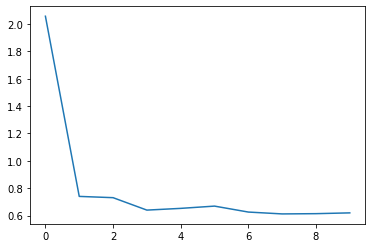

In [23]:
history = model.fit(x=X_train, y=y_train, epochs=10)
plt.plot(history.history['loss'])

Watch that training loss go! Our model is really learning! Notice that the optimization algorithm we selected stochastic gradient descent `model.compile(optimizer='sgd', ...)` is *stochastic*. It only estimates the optimal gradient values from statistical samples against the dataset at each epoch. Don't be surprised then to see the loss jump up and down a bit. Still, it generally makes progress towards convergence. Let's see if more iterations improve the model further:

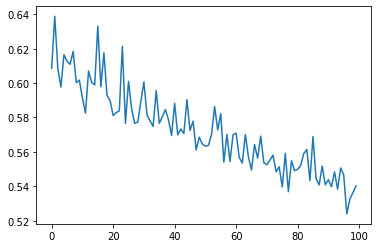

In [24]:
history = model.fit(x=X_train, y=y_train, epochs=100, verbose=0)
plt.plot(history.history['loss'])

Notice that now training doesn't improve so quickly. In fact, as loss decreases, we start to approach the Bayesian error bound which is a theoretical minimum for any classification system, and as our classifier approaches that phase boundary, it begins to oscillate even more violently. We could use a few tricks to minimize stachasticity like turning down the learning rate, cahanging the optimizer, or regularizing the weights, activations, gradients, or error, but in the end there's no getting around the impossible.

## Congradulations

We still haven't gone over validation sets, regularization, or pipeline construction, but take a moment to relax and congradulate yourself for building and training your very own neural network. Maybe celebrate by
- sharing this post with your friends
- visiting [arxiv.org](https://arxiv.org) and reading a interesting paper on AI.
- testing your model on unseen data

## Test Data

If you chose the latter option, go ahead and load your test data into neural-network-readable format using the before proceedure:

In [25]:
test_data_modified = test_data.copy()
test_data_modified['Sex'] = test_data_modified.apply(
    lambda x : 0 if x.Sex == 'male' else 1, axis=1)
test_data_modified['Embarked'] = test_data_modified.apply(
    lambda x : mapE(x.Embarked), axis=1)

for k in ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']:
    test_data_modified[k] = test_data_modified[k].apply(
        lambda x : 0 if np.isnan(x) else x)
test_data_modified

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,2
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,0.0,0,0,A.5. 3236,8.0500,NaN,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,1
415,1307,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0
416,1308,3,"Ware, Mr. Frederick",0,0.0,0,0,359309,8.0500,NaN,0


I had to remove the `'Survived'` column since it wasn't there. (It's test data after all!) Also, while scrolling through the list of methods under `train_data`, I encountered the `dropna` method. It is a much cleaner solution to the previous 3-line for loop I used when cleaning `train_data`. I have kept the above code as origonally so you can see this overall development process.

In [26]:
test_data_modified = test_data_modified.drop(
    columns=['PassengerId', 'Name', 'SibSp', 'Ticket', 'Cabin'])
test_data_modified

,Pclass,Sex,Age,Parch,Fare,Embarked
0,3,0,34.5,0,7.8292,2
1,3,1,47.0,0,7.0000,0
2,2,0,62.0,0,9.6875,2
3,3,0,27.0,0,8.6625,0
4,3,1,22.0,1,12.2875,0
...,...,...,...,...,...,...
413,3,0,0.0,0,8.0500,0
414,1,1,39.0,0,108.9000,1
415,3,0,38.5,0,7.2500,0
416,3,0,0.0,0,8.0500,0


In [27]:
X_test = test_data_modified.to_numpy()
X_test[:10]

array([[ 3.    ,  0.    , 34.5   ,  0.    ,  7.8292,  2.    ],
       [ 3.    ,  1.    , 47.    ,  0.    ,  7.    ,  0.    ],
       [ 2.    ,  0.    , 62.    ,  0.    ,  9.6875,  2.    ],
       [ 3.    ,  0.    , 27.    ,  0.    ,  8.6625,  0.    ],
       [ 3.    ,  1.    , 22.    ,  1.    , 12.2875,  0.    ],
       [ 3.    ,  0.    , 14.    ,  0.    ,  9.225 ,  0.    ],
       [ 3.    ,  1.    , 30.    ,  0.    ,  7.6292,  2.    ],
       [ 2.    ,  0.    , 26.    ,  1.    , 29.    ,  0.    ],
       [ 3.    ,  1.    , 18.    ,  0.    ,  7.2292,  1.    ],
       [ 3.    ,  0.    , 21.    ,  0.    , 24.15  ,  0.    ]])

Now let's make our predictions:

In [28]:
y_test = model.predict(X_test)
y_test = y_test[:,0]
y_test = y_test > 0.5
y_test = y_test.astype(int)
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

It looks like most of these passengers survived! We need to convert this back into the submission CSV format. This means we need to associate each output value with the passenger ID. Since everything is still in order, we can use Python's zip enumerate feature to pairwise associate and enumerate over the two:

In [29]:
submission_vals = list()
for passengerId, survived in zip(test_data['PassengerId'], y_test):
    submission_vals.append((passengerId, survived))
submission_vals[:10]

[(892, 0),
 (893, 0),
 (894, 0),
 (895, 0),
 (896, 0),
 (897, 0),
 (898, 0),
 (899, 0),
 (900, 0),
 (901, 0)]

Now let's write it to a CSV and submit!

In [30]:
submission_df = pd.DataFrame(submission_vals, 
                             columns=['PassengerId', 'Survived'])
submission_df.to_csv('~/Downloads/titanic_submission.csv', index=0)  # I had to look up on stack overflow how to remove the index column
submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


(I got 49000th place)

## Appendix: Parsing textual data

You may be curious how to parse text data meaningfully. There are quick tricks and deep answers to that question. First, a simple approach is to map each character or word to a unique dimension index. Keras supports this with the `preprocessing` api:

In [31]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(['Your', 'text'])
seq = tokenizer.texts_to_sequences(["This is some sample text"])
seq = np.array(seq)
seq

array([[2]])

Then you can feed this input to an `Embedding` layer, which will make a high-dimensional semantically 'meaningful' vector embedding of the word tokens. 

In [32]:
emb_layer = tf.keras.layers.Embedding(input_dim=1000, output_dim=50)
emb_layer(seq)

<tf.Tensor: shape=(1, 1, 50), dtype=float32, numpy=
array([[[-0.03666707, -0.0117747 , -0.01397576, -0.03344081,
          0.00617025, -0.00786964, -0.0313362 , -0.02986075,
         -0.04250616,  0.03273335,  0.03770379, -0.0225114 ,
         -0.02535275, -0.03679086, -0.02828252, -0.01776195,
          0.01099538,  0.04877671, -0.03985844, -0.00252389,
         -0.04078058,  0.04710824,  0.04433593, -0.04815951,
          0.01366485,  0.03712184,  0.01594793,  0.04662714,
          0.04077223,  0.04944262,  0.03550125,  0.0411897 ,
          0.02776184,  0.00730548,  0.04782952,  0.0046821 ,
          0.01143534, -0.02176028, -0.04670025, -0.0265502 ,
          0.04350844,  0.02636589, -0.00414578,  0.03208989,
          0.00499483,  0.03859944,  0.03411831, -0.04564637,
         -0.0142778 , -0.02033343]]], dtype=float32)>

Great! Now your dense layers and other layers can start learning the tokenizer's language to parse words (or characters) in order to understand natural language columns.

A faster (actually computationally slower, but faster to develop) and more complete solution is just to use off-the-shelf transformers like GPT.

In [33]:
import transformers

In [34]:
gpt_tokenizer = transformers.OpenAIGPTTokenizer.from_pretrained('openai-gpt')
gpt_model = transformers.OpenAIGPTModel.from_pretrained('openai-gpt')

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [35]:
tokens = gpt_tokenizer.encode("some text input", return_tensors='tf')
text_encoding = gpt_model(tokens)

AttributeError: 
        'EagerTensor' object has no attribute 'size'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

I didn't realize you need pytorch by default.

In [37]:
import torch

In [38]:
tokens = gpt_tokenizer.encode("some text input", return_tensors='pt')
text_encoding = gpt_model(tokens)

In [39]:
text_encoding

BaseModelOutput(last_hidden_state=tensor([[[ 0.0882,  0.0539,  0.3581,  ...,  0.1716, -0.7176,  0.3359],
         [ 0.0464,  0.3434,  0.2813,  ...,  0.3462, -0.6462,  0.5508],
         [ 0.5369,  0.1385,  1.0945,  ...,  0.2260, -0.4896,  0.2685]]],
       grad_fn=<ViewBackward>), hidden_states=None, attentions=None)

You now have a highly informative vector representation. With pretrained transformers, you are generally good to go for advanced text data extraction.